<a href="https://colab.research.google.com/github/chrisrichardson/linear-algebra/blob/main/03_Sparse_Matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Import required libraries
!pip install pyamg
import pyamg
from scipy.linalg import lu
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import lil_matrix
import numpy as np
import matplotlib.pyplot as plt

`pyamg` contains a useful gallery of sparse matrices. We will create a finite difference stencil matrix for a poisson equation on a 3D cuboid with dimension `(5, 5, 15)`.

In [52]:
# Get the matrix in CSR format
A = pyamg.gallery.poisson((5, 5, 15)).tocsr()

# We can inspect the row pointer, column indices, and values directly (say, for first three rows)

for i in range(3):
    print('row:', i, 'ncols:', A.indptr[i+1] - A.indptr[i])
    print('cols:', A.indices[A.indptr[i]:A.indptr[i+1]])
    print('vals:', A.data[A.indptr[i]:A.indptr[i+1]])

row: 0 ncols: 4
cols: [ 0  1 15 75]
vals: [ 6. -1. -1. -1.]
row: 1 ncols: 5
cols: [ 0  1  2 16 76]
vals: [-1.  6. -1. -1. -1.]
row: 2 ncols: 5
cols: [ 1  2  3 17 77]
vals: [-1.  6. -1. -1. -1.]


[[ 6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [-1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.

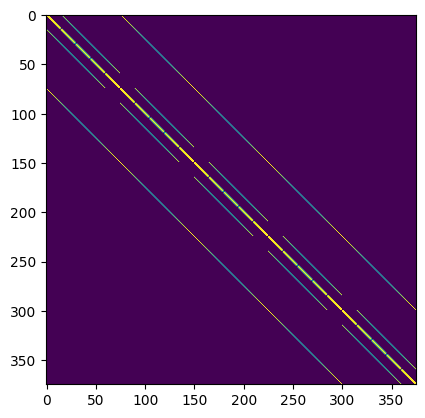

In [53]:
# We can take a look at the top corner, but it is too big to look at the whole matrix.
# Convert to a "dense" matrix to view
Atop_corner = A[:18, :18].todense()
print(Atop_corner)

# To visualise the whole matrix, just plot non-zeros (in yellow)
plt.imshow(A.todense() != 0);

`scipy` has an interface for LU factorisation, so we can factorise (and hence solve), if we have a suitable right-hand side. The LU factorisation also does pivoting, but because this matrix has a dominant diagonal term, it isn't needed here. It only works for dense matrices.

In [54]:
# Get the pivot permutation and LU factorisation
P, L, U = lu(A.todense())

### Sparseness of L and U

To use the `scipy` routine, we had to convert back to a "dense" matrix, including all zeros.

In a sparse LU solver, we wouldn't store the zeros in `A`, `L` or `U`, but use a sparse format.


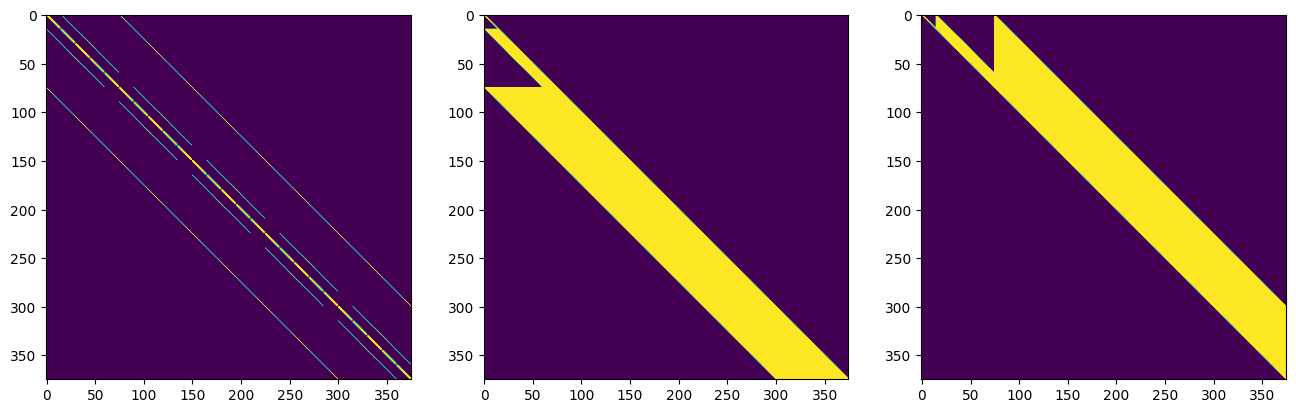

In [55]:
# Plot the non-zeros in L and U
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.imshow(A.todense() != 0);
plt.subplot(1, 3, 2)
plt.imshow(L!=0)
plt.subplot(1, 3, 3)
plt.imshow(U!=0);

### Exercise

Compute the number of non-zeros in A, L and U. Use the `np.count_nonzero` function.

In [ ]:
#@title Solution to exercise
print(np.count_nonzero(L))
print(np.count_nonzero(U))
print(np.count_nonzero(A.todense()))

### In-fill

The LU factorisation process has resulted in "in-fill" between the diagonal and the furthest row-entry from the diagonal of `A`.
This is undesirable, as it results in a large increase in storage requirement, and also more computation and memory traffic.

Since we can rearrange the rows and columns of `A`, it is possible to minimise the in-fill. A graph ordering routine, such as "Cuthill-McKee" can be used to permute the rows and columns.


### Exercise

Compute the reordering of `A`, and make a new reordered matrix `M`. The ordering can be got from the `scipy` routine `reverse_cuthill_mckee(A)`.
There are many different ways to apply the permutation. If you get stuck, there is one possible solution below...

In [ ]:
#@title Solution to exercise

p = np.argsort(reverse_cuthill_mckee(A))

M = lil_matrix(A.shape)
for i in range(A.shape[0]):
    r = A.indices[A.indptr[i]:A.indptr[i+1]]
    d = A.data[A.indptr[i]:A.indptr[i+1]]
    for indx, val in zip(r, d):
        M[p[i], p[indx]] = val

P, L, U = lu(M.todense())

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(M.todense() != 0);
plt.subplot(1, 3, 2)
plt.imshow(L!=0)
plt.subplot(1, 3, 3)
plt.imshow(U!=0);


### Easy exercise

Compute the number of non-zeros, and compare to previous (without permutation).

Hopefully, the number of non-zeros in L and U should be much smaller than before...
This is how most LU solver packages work - there is a lot of technical detail involved in reordering, both for reducing in-fill and improving stability (i.e. pivoting).